In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from utils import *
from pycaret.regression import *
import warnings

warnings.filterwarnings('ignore')
%config Completer.use_jedi = False
seed = 1

In [13]:
stacker = load_model("model/stacked_regressior_01")
stacker_tuned = load_model("model/stacked_tuned_regressior_01")

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [56]:
top3 = compare_models(n_select = 3,sort = 'MSE',
                      exclude=['huber','lar','par', 'knn', 'llar', 'br', 'en','lr'],
                      verbose=False)
stacker = stack_models(estimator_list = top3[1:], meta_model = top3[0], verbose=False)

In [5]:
df = pd.read_csv("data/imports-85.data", header=None, names=columns)
df = clean_df(df)

data = df.sample(frac=0.9, random_state=seed)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

164 rows (80.0%) left after preprocessing


In [7]:
cols = list(data.columns)
target, features = cols[0], cols[1:]

24

In [8]:
X,y = data[features], data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

In [19]:
params = {
    "data": data,
    "target": "normalized-losses",
    "train_size": 0.8,
    "categorical_features": [c for c in cols[1:] if c not in numerics],
    "remove_multicollinearity": True,
    "verbose": False,
    "silent": True,
    "fold": 10,
    "session_id": seed,
}
regr = setup(**params)

In [39]:
gbr = create_model('gbr',verbose=False)
save_model(gbr, "model/gbr_01")
print()

Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Succesfully Saved



In [28]:
gbr_tuned = tune_model(
    gbr,
    search_library="tune-sklearn",
    search_algorithm="optuna",
    n_iter=20,
    optimize = "MSE",
    verbose=False
)

save_model(gbr_tuned, "model/gbr_tuned_01")

[I 2021-05-06 19:35:36,139] A new study created in memory with name: optuna


In [35]:
y_hat = predict_model(stacker,X_test)["Label"]
print("MSE Stacked:      ",round(mean_squared_error(y_test, y_hat),2))

y_hat = predict_model(stacker_tuned,X_test)["Label"]
print("MSE Stacked Tuned:",round(mean_squared_error(y_test, y_hat),2))

y_hat = predict_model(gbr,X_test)["Label"]
print("MSE GBR:          ",round(mean_squared_error(y_test, y_hat),2))

y_hat = predict_model(gbr_tuned,X_test)["Label"]
print("MSE GBR Tuned:    ",round(mean_squared_error(y_test, y_hat),2))

MSE Stacked:       248.99
MSE Stacked Tuned: 265.85
MSE GBR:           143.74
MSE GBR Tuned:     223.24


In [48]:
models = {"gbr": gbr,
          "gbr_tuned": gbr_tuned}

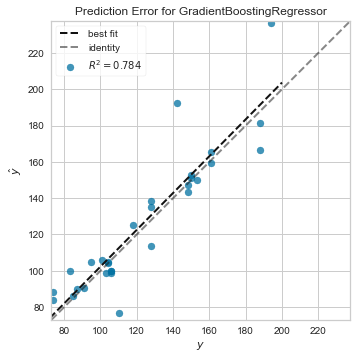

In [52]:
# Note: Somehow plotting does not work for unpickled models
plot_model(gbr, 'error')

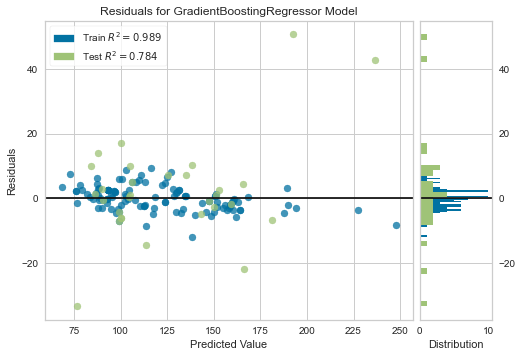

In [53]:
plot_model(gbr,"residuals")

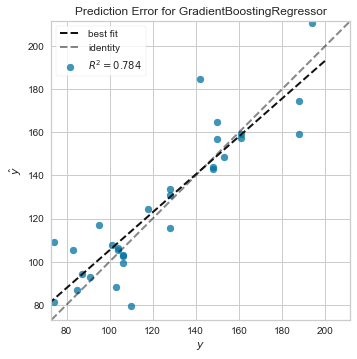

In [54]:
plot_model(gbr_tuned, 'error')

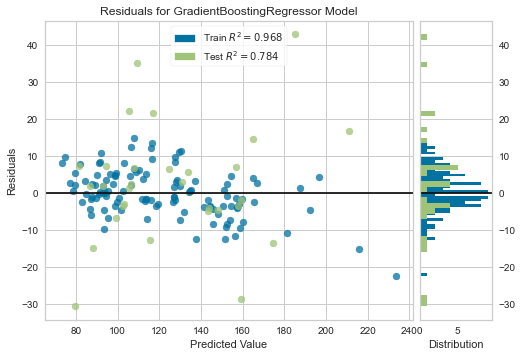

In [55]:
plot_model(gbr_tuned,"residuals")

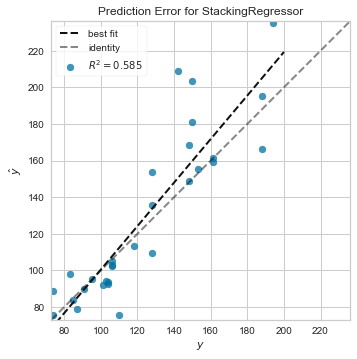

In [57]:
plot_model(stacker, 'error')

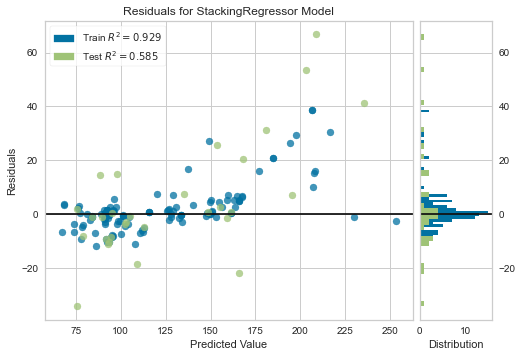

In [59]:
plot_model(stacker, 'residuals')

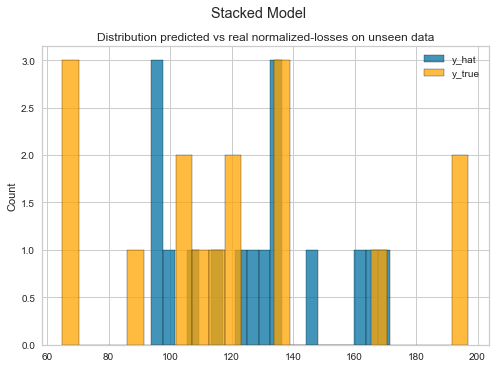

In [60]:
predictions = predict_model(stacker_tuned, 
                            data = data_unseen[
                                list(data_unseen.columns)[1:]
                            ])["Label"].to_numpy()

truth = data_unseen["normalized-losses"].to_numpy()

sns.histplot(predictions, bins=20)
sns.histplot(truth, bins=25, color="orange")
plt.suptitle("Stacked Model")
plt.title("Distribution predicted vs real normalized-losses on unseen data")
plt.legend(["y_hat", "y_true"])
#plt.savefig('img/dist_pred_vs_real_unseen_stacked.png', dpi=300)
plt.show()

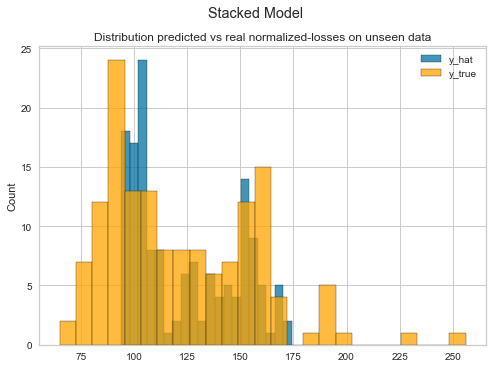

In [61]:
predictions = predict_model(stacker_tuned, 
                            data = data[
                                list(data.columns)[1:]
                            ])["Label"].to_numpy()

truth = data["normalized-losses"].to_numpy()

sns.histplot(predictions, bins=20)
sns.histplot(truth, bins=25, color="orange")
plt.suptitle("Stacked Model")
plt.title("Distribution predicted vs real normalized-losses on unseen data")
plt.legend(["y_hat", "y_true"])
#plt.savefig('img/dist_pred_vs_real_unseen_stacked.png', dpi=300)
plt.show()